In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

In [21]:
dir_root = get_project_root()
dir_data = 'data'
filename_data_brain = os.path.join(
    dir_root,
    dir_data, 
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/tmp/ipykernel_16683/801828396.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [22]:
data = clean_data(data_raw)

For an initial look, let's just define a list of some of the  columns that look interesting.

## Train-Test Split

In [23]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [24]:
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=2984, 
    shuffle=True, 
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test , y_test  = split_X_and_y_data(data_test)

In [25]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61140 entries, 57582 to 62886
Data columns (total 125 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Age recode with <1 year olds                                           61140 non-null  int64   
 1    Sex                                                                    61140 non-null  category
 2    Year of diagnosis                                                      61140 non-null  int64   
 3    PRCDA 2020                                                             61140 non-null  object  
 4    Race recode (W, B, AI, API)                                            61140 non-null  category
 5    Origin recode NHIA (Hispanic, Non-Hisp)                                61140 non-null  category
 6    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)           

## Model Training

### Train a very simple model without a pipeline

In [26]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

In [27]:
X_subset_train = X_train[['Age recode with <1 year olds','Year of diagnosis']]

estimator = CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
estimator.fit(pd.DataFrame(X_subset_train), y_train.to_records(index=False))

CoxnetSurvivalAnalysis(fit_baseline_model=True, verbose=True)

In [28]:
estimator.score(X_subset_train, y_train.to_records(index=False))

KeyboardInterrupt: 

In [ ]:
X_to_pred = pd.DataFrame.from_dict(
    {
        1: [20, 2010],
        2: [40, 2005],
        3: [60, 2020],
        4: [80, 2020],
    },
    columns=X_subset_train.columns,
    orient="index",
)
X_to_pred

,Age recode with <1 year olds,Year of diagnosis
1,20,2010
2,40,2005
3,60,2020
4,80,2020


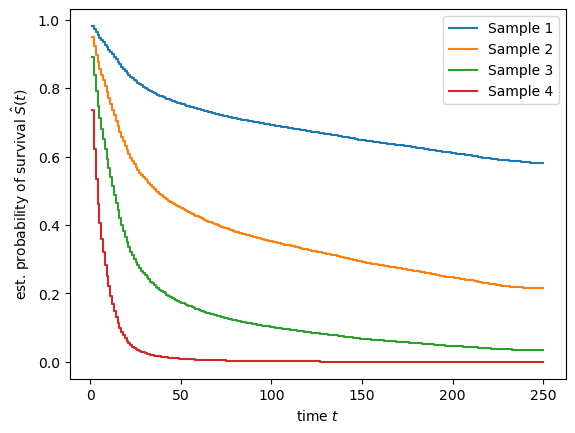

In [ ]:
pred_surv = estimator.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### Pipeline analysis

work in progress

In [ ]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['Sex']),
    (StandardScaler(), ['Age recode with <1 year olds']),
    remainder='drop'
)

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

In [ ]:
pipeline = make_pipeline(
    column_transformer, 
    # SelectKBest(fit_and_score_features, k=1),
    CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
)

cv_search_dist = {
    'coxnetsurvivalanalysis__l1_ratio': np.linspace(0.8, 1, 5)
}
# cv_search = RandomizedSearchCV(
cv_search = GridSearchCV(
    pipeline, 
    cv_search_dist, 
    cv=3,
)
cv_search.fit(X_train, y_train.to_records(index=False))
# cv_search.score(X_train, y_train.to_records(index=False))

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Sex']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age '
                                                                          'recode '
                                                                          'with '
                                                                          '<1 '
                                                                          'year '
                                                                          'olds'])])),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                                               verbose=True))]),
             param_grid={'coxnetsurvivalanalysis__l1_ratio': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])})

In [ ]:
cv_search.score(X_train, y_train.to_records(index=False))

0.7352880861546051

In [ ]:
cv_search.best_params_

{'coxnetsurvivalanalysis__l1_ratio': 0.8}

It's interesting that `l1_ratio = 0.8` is preferred here. I'm not sure what to make of it. Maybe the model is so simple that we're getting weird behavior? I thought we should expect a value closer to 1. 

In [ ]:
X_to_pred = pd.DataFrame.from_dict(
    {
        1: X_train.iloc[0],
        2: X_train.iloc[1],
    },
    columns=X_train.columns,
    orient="index",
)
pred_surv = cv_search.best_estimator_.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

AttributeError: Can only use .cat accessor with a 'category' dtype